# ESRB Rating Project

## Table Of Contents
<font size=3rem>
    
0 -**[ INTRO](#INTRODUCTION)<br>**
1 -**[ OBTAIN](#OBTAIN)**<br>
2 -**[ SCRUB](#SCRUB)**<br>
3 -**[ EXPLORE](#EXPLORE)**<br>
4 -**[ MODEL](#MODEL)**<br>
5 -**[ INTERPRET](#INTERPRET)**<br>
6 -**[ CONCLUSIONS & RECCOMENDATIONS](#Conclusions-&-Recommendations)<br>**
</font>
___

# INTRODUCTION

- Student: Cody Freese
- Pace: Self Paced
- Jeff Herman

## Import Tools

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb

import statsmodels as sm

import sklearn.preprocessing as preprocessing

from sklearn.ensemble import (RandomForestClassifier,
                              RandomForestRegressor)

from sklearn.tree import (DecisionTreeClassifier,
                          DecisionTreeRegressor)

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import (classification_report, 
                             confusion_matrix)

from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Classification Function
def classification(X_train, y_train,X_test,y_test, classifier):
    y_pred = classifier.predict(X_test)
    fig, ax = plt.subplots(figsize=(8,8))
    plot_confusion_matrix(estimator=classifier, X=X_test, y_true=y_test, ax=ax)
    plt.show()
    print(classification_report(y_test, y_pred))
    print(f'Accuracy:{round(accuracy_score(y_test,y_pred)*100, 2)}%')

In [88]:
def plot_game_consoles(df):
    # Combine titles into new category if they appear on both consoles.
    value_count_dct = {}
    for title, console in df[['title', 'console']].values:
        if title in value_count_dct and value_count_dct[title] != console:
            value_count_dct[title] = 'Available on Both'
        else:
            value_count_dct[title] = 'Xbox' if console == 1 else 'Playstation'
    engineered_series = pd.Series(value_count_dct).value_counts()
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    engineered_series.plot(kind='bar', ax=ax1)
    engineered_series.plot(kind='pie', ax=ax2)
    # SET TITLE AND STUFF HERE
    ax1.set(title='Bar Graph Distribution For Console Type', xlabel='X', ylabel='X')
    ax2.set(title='', xlabel='P', ylabel='P')
    fig.tight_layout()
    plt.show()

# OBTAIN

In [4]:
# Import Test CSV
test_df = pd.read_csv('test_esrb.csv')
test_df.info()
# Import Train CSV
train_df = pd.read_csv('Video_games_esrb_rating.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   title                     500 non-null    object
 1   console                   500 non-null    int64 
 2   alcohol_reference         500 non-null    int64 
 3   animated_blood            500 non-null    int64 
 4   blood                     500 non-null    int64 
 5   blood_and_gore            500 non-null    int64 
 6   cartoon_violence          500 non-null    int64 
 7   crude_humor               500 non-null    int64 
 8   drug_reference            500 non-null    int64 
 9   fantasy_violence          500 non-null    int64 
 10  intense_violence          500 non-null    int64 
 11  language                  500 non-null    int64 
 12  lyrics                    500 non-null    int64 
 13  mature_humor              500 non-null    int64 
 14  mild_blood                

In [5]:
#Combine the Train/Test CSVs into one
combined_csv = test_df.append(train_df)
combined_csv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2395 entries, 0 to 1894
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   title                     2395 non-null   object
 1   console                   2395 non-null   int64 
 2   alcohol_reference         2395 non-null   int64 
 3   animated_blood            2395 non-null   int64 
 4   blood                     2395 non-null   int64 
 5   blood_and_gore            2395 non-null   int64 
 6   cartoon_violence          2395 non-null   int64 
 7   crude_humor               2395 non-null   int64 
 8   drug_reference            2395 non-null   int64 
 9   fantasy_violence          2395 non-null   int64 
 10  intense_violence          2395 non-null   int64 
 11  language                  2395 non-null   int64 
 12  lyrics                    2395 non-null   int64 
 13  mature_humor              2395 non-null   int64 
 14  mild_blood              

# SCRUB

- Datatypes appear correct

## Pivot Table, Describe & Counts

In [6]:
#Organized table by Rating and Console, used as organization check
combined_csv.pivot_table(index=["esrb_rating","console"])

alcohol_reference  animated_blood     blood  \
esrb_rating console                                                
E           0                 0.035857        0.000000  0.000000   
            1                 0.033962        0.000000  0.000000   
ET          0                 0.129747        0.006329  0.000000   
            1                 0.061033        0.037559  0.000000   
M           0                 0.000000        0.000000  0.436275   
            1                 0.003663        0.000000  0.388278   
T           0                 0.039916        0.010504  0.430672   
            1                 0.073048        0.012594  0.387909   

                     blood_and_gore  cartoon_violence  crude_humor  \
esrb_rating console                                                  
E           0              0.000000          0.000000     0.003984   
            1              0.000000          0.000000     0.007547   
ET          0              0.000000          0.006329     0.069620   
            1              0.000000          0.117371     0.061033   
M           0              0.406863          0.000000     0.029412   
            1              0.578755          0.000000     0.003663   
T           0              0.084034          0.010504     0.048319   
            1              0.060453          0.040302     0.138539   

                     drug_reference  fantasy_violence  intense_violence  \
esrb_rating console                                                       
E           0              0.000000          0.000000          0.000000   
            1              0.000000          0.000000          0.000000   
ET          0              0.012658          0.715190          0.085443   
            1              0.037559          0.582160          0.084507   
M           0              0.053922          0.117647          0.186275   
            1              0.069597          0.095238          0.315018   
T           0              0.056723          0.222689          0.132353   
            1              0.032746          0.113350          0.075567   

                     language  ...  partial_nudity  sexual_content  \
esrb_rating console            ...                                   
E           0        0.000000  ...        0.000000        0.000000   
            1        0.000000  ...        0.000000        0.000000   
ET          0        0.072785  ...        0.003165        0.000000   
            1        0.070423  ...        0.000000        0.000000   
M           0        0.161765  ...        0.068627        0.112745   
            1        0.172161  ...        0.069597        0.073260   
T           0        0.195378  ...        0.027311        0.050420   
            1        0.148615  ...        0.017632        0.020151   

                     sexual_themes  simulated_gambling  strong_janguage  \
esrb_rating console                                                       
E           0             0.000000            0.000000         0.000000   
            1             0.000000            0.000000         0.000000   
ET          0             0.000000            0.009494         0.000000   
            1             0.000000            0.004695         0.004695   
M           0             0.230392            0.142157         0.500000   
            1             0.117216            0.124542         0.509158   
T           0             0.039916            0.048319         0.008403   
            1             0.040302            0.120907         0.010076   

                     strong_sexual_content  suggestive_themes  use_of_alcohol  \
esrb_rating console                                                             
E           0                     0.000000           0.000000        0.000000   
            1                     0.000000           0.000000        0.000000   
ET          0                     0.006329           0.075949        0.025316   
            1                  

In [7]:
#Checking values, values <= 1% Mean
#Animated_Blood
combined_csv.describe()

,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,intense_violence,...,partial_nudity,sexual_content,sexual_themes,simulated_gambling,strong_janguage,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence
count,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,...,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.00000,2395.000000,2395.000000
mean,0.479332,0.050522,0.008351,0.231315,0.127349,0.020042,0.051357,0.034238,0.230063,0.109395,...,0.022547,0.031315,0.047599,0.057620,0.104384,0.038831,0.108977,0.03048,0.022965,0.114823
std,0.499677,0.219065,0.091019,0.421762,0.333433,0.140172,0.220771,0.181878,0.420961,0.312199,...,0.148485,0.174205,0.212961,0.233072,0.305822,0.193232,0.311675,0.17194,0.149822,0.318874
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [8]:
#Get a count of possible duplicate titles that exist in both console categories (Binary Yes/No)
#Count of Yes/No for each variable
for column in combined_csv:
    print(combined_csv[column].value_counts())

Super GunWorld 2                            2
RAID: WORLD WAR II                          2
Transport Giant                             2
ADK DAMASHII                                2
The Inner World                             2
                                           ..
Dungeon of the Endless                      1
Bunny Must Die! Chelsea and the 7devils.    1
The Grand Tour Game                         1
Songbringer                                 1
Fade to Silence                             1
Name: title, Length: 2332, dtype: int64
0    1247
1    1148
Name: console, dtype: int64
0    2274
1     121
Name: alcohol_reference, dtype: int64
0    2375
1      20
Name: animated_blood, dtype: int64
0    1841
1     554
Name: blood, dtype: int64
0    2090
1     305
Name: blood_and_gore, dtype: int64
0    2347
1      48
Name: cartoon_violence, dtype: int64
0    2272
1     123
Name: crude_humor, dtype: int64
0    2313
1      82
Name: drug_reference, dtype: int64
0    1844
1     551
Name: fa

In [9]:
pd.DataFrame(combined_csv["title"].value_counts()[combined_csv["title"].value_counts() > 1]).index
#Count of Duplicate Titles across platforms

Index(['Super GunWorld 2', 'RAID: WORLD WAR II', 'Transport Giant',
       'ADK DAMASHII', 'The Inner World', '>Observer_', 'Serial Cleaner',
       'Cosmic Star Heroine', 'Unbox - Newbie's Adventure',
       'Pillars of Eternity', 'Narcosis', 'Human Fall Flat', 'Aaero', 'Jak 3',
       'BUTCHER', 'Late Shift', 'Super Comboman: Smash Edition',
       'The Metronomicon: Slay the Dance Floor', 'Double Dragon 4',
       'The Long Dark', 'forma.8', 'Polybius', 'Windjammers',
       'Future Unfolding', 'What Remains of Edith Finch',
       'Paranormal Activity: The Lost Soul', 'Kill The Bad Guy',
       'BLACKHOLE: Complete Edition', 'ICEY', 'Island Flight Simulator',
       'Joe's Diner', 'Thimbleweed Park', '88 Heroes', 'Duck Game',
       'Wonder Boy: The Dragon's Trap', 'INSIDE', 'SHINY', 'Crawl',
       'South Park: The Stick of Truth',
       'Momodora: Reverie Under the Moonlight',
       'River City Melee: Battle Royal Special', 'Nex Machina', 'Kero Blaster',
       '2064: Read Only

In [10]:
#Number of duplicates in value count list
len(pd.DataFrame(combined_csv["title"].value_counts()[combined_csv["title"].value_counts() > 1]).index)

63

In [11]:
# 63 games that exist on both platforms but my function doens't catch

In [12]:
combined_csv[combined_csv['title']=="South Park: The Stick of Truth"]
#Variables don't match for the same game/sometimes same console
#South Park used as example
#Future Work could include further decision making about which to keep/drop/etc

,title,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,...,sexual_content,sexual_themes,simulated_gambling,strong_janguage,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence,esrb_rating
16,South Park: The Stick of Truth,1,0,0,0,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,M
1514,South Park: The Stick of Truth,1,0,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,M


# EXPLORE

## EDA by Platform

In [13]:
#Where Duplicated Titles
combined_csv.drop_duplicates(inplace=True)
#Rows where titles are duplicated, consoles are different AND will drop row if the row is an exact duplicate
combined_csv[combined_csv['title'].duplicated(keep=False)]

,title,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,...,sexual_content,sexual_themes,simulated_gambling,strong_janguage,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence,esrb_rating
0,Still Time,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,T
2,The Metronomicon: Slay the Dance Floor,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,T
16,South Park: The Stick of Truth,1,0,0,0,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,M
22,Mages of Mystralia,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,ET
31,Super Comboman: Smash Edition,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,ET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1720,Crawl,0,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,T
1810,The Inner World,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,T
1833,RAID: WORLD WAR II,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,M
1885,Pillars of Eternity,1,0,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,M


In [14]:
#Value count dictionary, if the title exists in both consoles will make 3rd category called Available on Both
value_count_dct = {}
for title, console in combined_csv[['title', 'console']].values:
    if title in value_count_dct and value_count_dct[title] != console:
        value_count_dct[title] = 'Available on Both'
    else:
        value_count_dct[title] = console

<AxesSubplot:>

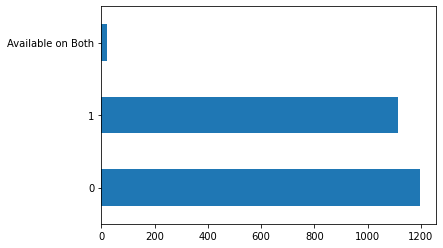

In [15]:
#horizontal bar graph visualization of overlap
pd.Series(value_count_dct).value_counts().plot(kind='barh')

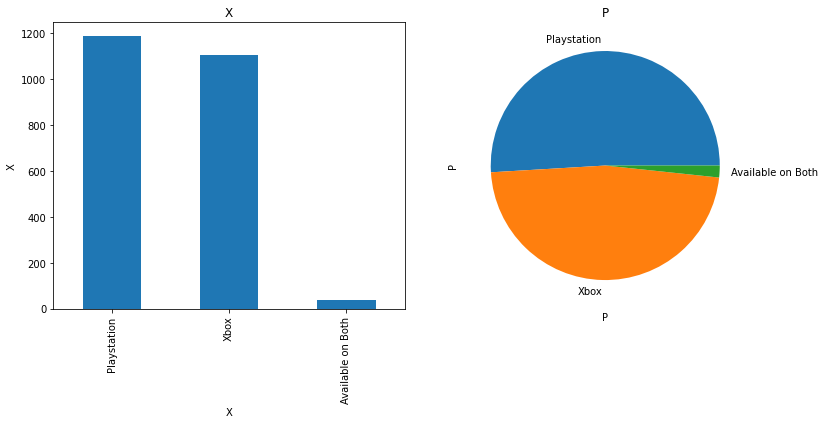

In [89]:
#Game Distribution & visualization of overlap
plot_game_consoles(combined_csv)

In [17]:
# pie = pd.DataFrame(combined_csv['esrb_rating'])

In [18]:
# labels = 'E','ET','T','M'
# sizes = pie
# plt.pie(sizes,labels=labels,autopct='%1.2f%%')
# plt.show()

In [19]:
# labels = 'E','ET','T','M'
# sizes = combined_csv["esrb_rating"].map(str)
# plt.pie(sizes,labels=labels,autopct='%1.2f%%')
# plt.show()

## Correlation

In [20]:
# # One Hot Encoding Ratings
# mapp = { 'E' : 0,
#           'ET': 1,
#           'T' : 2,
#           'M' : 3,}

# combined_csv['esrb_rating'] = combined_csv['esrb_rating'].map(mapp)

In [21]:
# subjective_corr = combined_csv.corr()
# subjective_corr[np.abs(subjective_corr)<.2]=0
# mask = np.zeros_like(subjective_corr, dtype=np.bool)

In [22]:
# fig, ax = plt.subplots(figsize=(25,20))
# corr = combined_csv.corr().round(3)
# sb.heatmap(corr, annot=True,ax=ax, mask=mask)
# plt.setp(ax.get_xticklabels(), 
#          rotation=45, 
#          ha="right",
#          rotation_mode="anchor")
# ax.set_title('Correlations')
# fig.tight_layout()

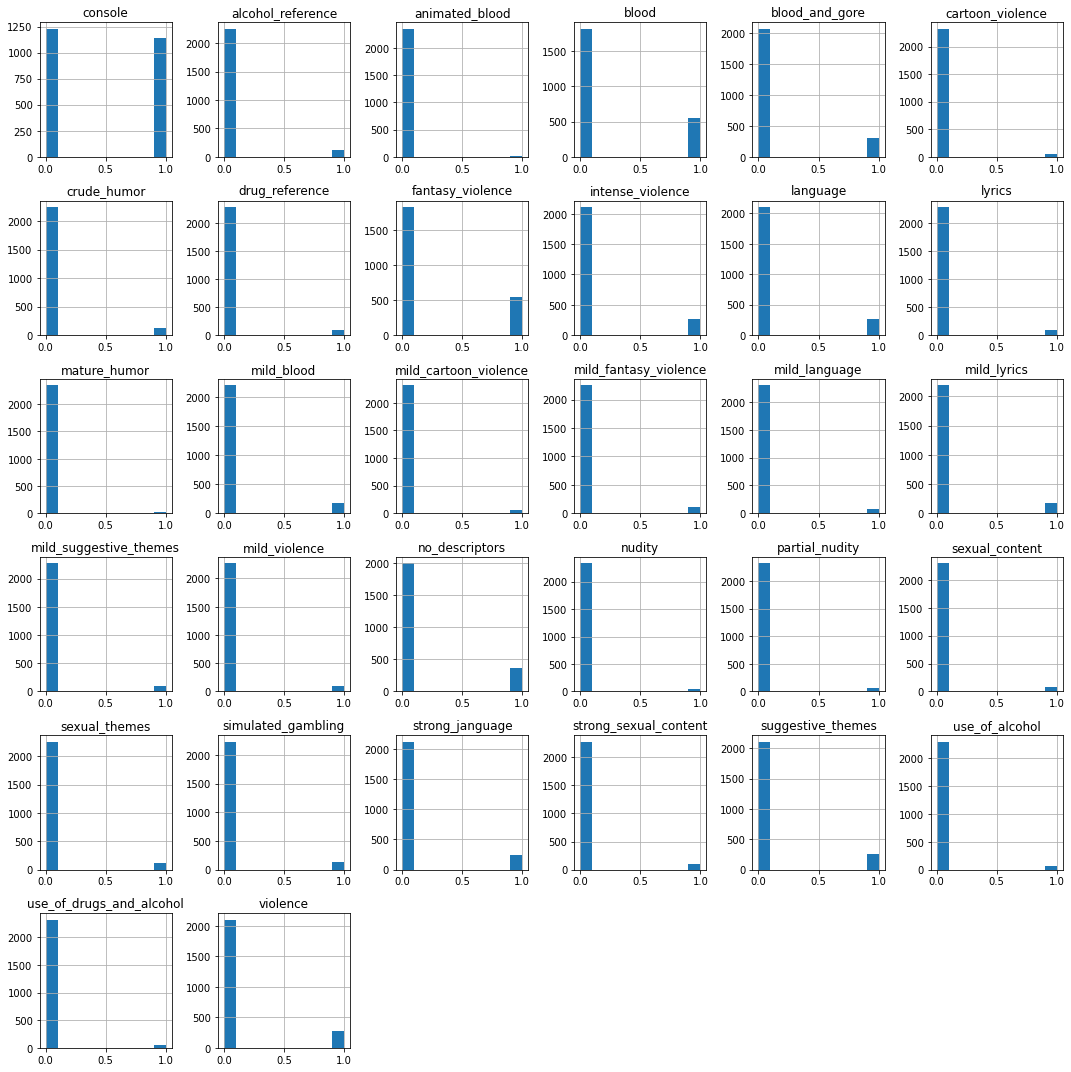

In [23]:
combined_csv.hist(figsize=(15,15))
plt.tight_layout()

# MODEL

## Train Test Split

In [24]:
#X variables drop Rating and Title
X = combined_csv.drop(['esrb_rating', 'title'],1)

#Y variable is Rating
y = combined_csv[['esrb_rating']]

#Train test split 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 354681)

## Initial Model

### Decision Tree

In [25]:
#decision tree, initial classifier, no parameters
dtc = DecisionTreeClassifier()
#fit decision tree to train test split
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [26]:
#Initial dtc training score
dtc.score(X_train, y_train)

0.9282700421940928

In [27]:
#Initial dtc test score
dtc.score(X_test, y_test)

0.8441011235955056

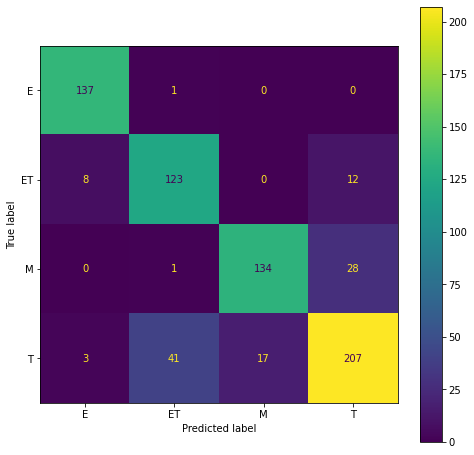

              precision    recall  f1-score   support

           E       0.93      0.99      0.96       138
          ET       0.74      0.86      0.80       143
           M       0.89      0.82      0.85       163
           T       0.84      0.77      0.80       268

    accuracy                           0.84       712
   macro avg       0.85      0.86      0.85       712
weighted avg       0.85      0.84      0.84       712

Accuracy:84.41%


In [28]:
#Confusion matrix, initial dtc classifier
classification(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    classifier=dtc)

### KNN

In [29]:
#knn, initial classifier, no parameters
knn = KNeighborsClassifier()

#fit knn to train test split
knn.fit(X_train, y_train)

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [30]:
#Initial KNN training score
knn.score(X_train, y_train)

0.8444846292947559

In [31]:
#Initial knn test score
knn.score(X_test, y_test)

0.7879213483146067

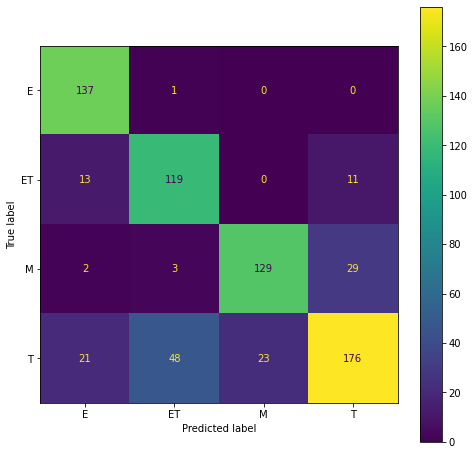

              precision    recall  f1-score   support

           E       0.79      0.99      0.88       138
          ET       0.70      0.83      0.76       143
           M       0.85      0.79      0.82       163
           T       0.81      0.66      0.73       268

    accuracy                           0.79       712
   macro avg       0.79      0.82      0.80       712
weighted avg       0.79      0.79      0.78       712

Accuracy:78.79%


In [32]:
#Confusion matrix, initial knn classifier
classification(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    classifier=knn)

### Random Forest

In [33]:
#rfc, initial classifier, no parameters
rfc = RandomForestClassifier()

#fit rfc to train test split
rfc.fit(X_train, y_train)

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestClassifier()

In [34]:
#Initial rfc training score
rfc.score(X_train, y_train)

0.9282700421940928

In [35]:
#Initial RFC test score
rfc.score(X_test, y_test)

0.8553370786516854

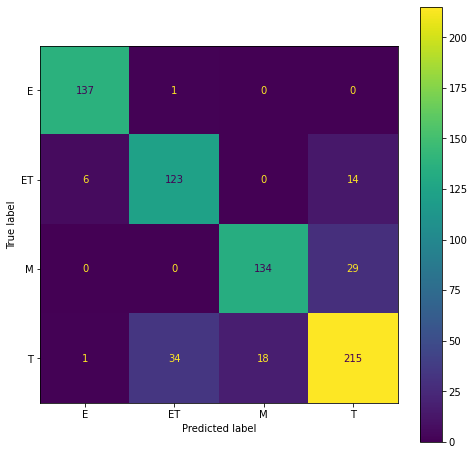

              precision    recall  f1-score   support

           E       0.95      0.99      0.97       138
          ET       0.78      0.86      0.82       143
           M       0.88      0.82      0.85       163
           T       0.83      0.80      0.82       268

    accuracy                           0.86       712
   macro avg       0.86      0.87      0.86       712
weighted avg       0.86      0.86      0.85       712

Accuracy:85.53%


In [36]:
#Confusion matrix, initial rfc classifier
classification(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    classifier=rfc)

# 1st Refined Models

### Decision Tree Refined Model

In [37]:
##Fit decision tree, applying parameters to refine search
dtc_param_grid1 = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [38]:
#GridSearchCV on DTC
dtc_grid_search1 = GridSearchCV(dtc, dtc_param_grid1, cv=3, return_train_score=True)

dtc_grid_search1.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True)

In [39]:
#Search for best estimator
bestdtcrefine1 = dtc_grid_search1.best_estimator_

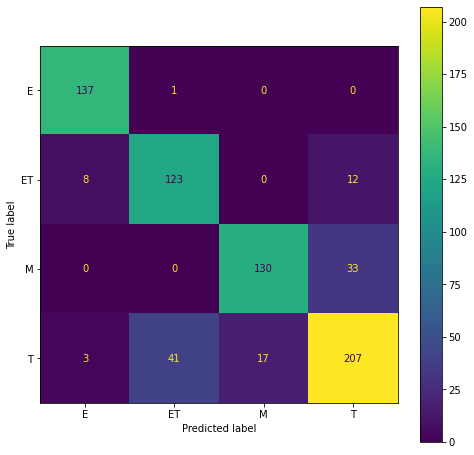

              precision    recall  f1-score   support

           E       0.93      0.99      0.96       138
          ET       0.75      0.86      0.80       143
           M       0.88      0.80      0.84       163
           T       0.82      0.77      0.80       268

    accuracy                           0.84       712
   macro avg       0.84      0.86      0.85       712
weighted avg       0.84      0.84      0.84       712

Accuracy:83.85%


In [40]:
#Confusion matrix
classification(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    classifier=bestdtcrefine1)

In [41]:
#search for best parameters
dtc_grid_search1.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [42]:
#1st Refine Model Test Score
bestdtcrefine1.score(X_test,y_test)

0.8384831460674157

In [43]:
#1st Refine Model Training Score
bestdtcrefine1.score(X_train,y_train)

0.9282700421940928

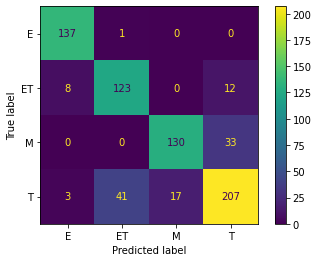

In [44]:
plot_confusion_matrix(estimator=bestdtcrefine1, X=X_test, y_true=y_test)

### KNN Refined Model

In [45]:
#Fit knn, applying parameters to refine search
knn_param_grid1 = {
    'n_neighbors': [3,5,7],
    'weights': ['uniform','distance'],
    'algorithm': ['ball_tree','kd_tree','brute'],
    'p':[1,2,3]
}

In [46]:
#GridSearch on Knn
knn_grid_search1 = GridSearchCV(knn, knn_param_grid1, cv=3, return_train_score=True)
#Fit 1st Refine KNN to Train/Test
knn_grid_search1.fit(X_train, y_train)

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 7], 'p': [1, 2, 3],
                         'weights': ['uniform', 'distance']},
             return_train_score=True)

In [47]:
#best estimator
bestknnrefine1 = knn_grid_search1.best_estimator_

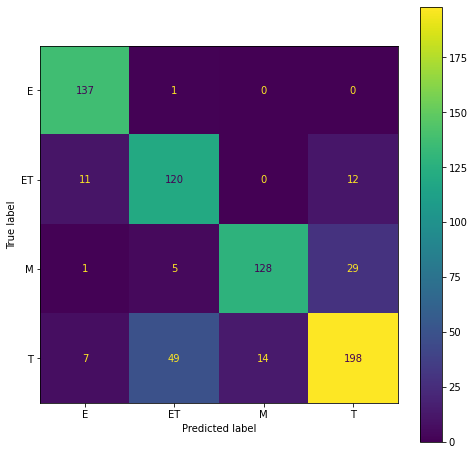

              precision    recall  f1-score   support

           E       0.88      0.99      0.93       138
          ET       0.69      0.84      0.75       143
           M       0.90      0.79      0.84       163
           T       0.83      0.74      0.78       268

    accuracy                           0.82       712
   macro avg       0.82      0.84      0.83       712
weighted avg       0.83      0.82      0.82       712

Accuracy:81.88%


In [48]:
#Knn confusion matrix
classification(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    classifier=bestknnrefine1)

In [49]:
#search for best parameters
knn_grid_search1.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 3, 'p': 3, 'weights': 'distance'}

In [50]:
#knn model test score
bestknnrefine1.score(X_test,y_test)

0.8188202247191011

In [51]:
#knn model training score
bestknnrefine1.score(X_train,y_train)

0.9276672694394213

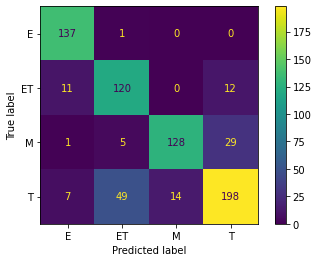

In [52]:
#confusion matrix results for trained data against test
plot_confusion_matrix(estimator=bestknnrefine1, X=X_test, y_true=y_test)

### Random Forest Refined

In [53]:
##Fit random forest, applying parameters to refine search
rfc_param_grid1 = {
    'n_estimators': [50,100],
    'criterion': ['gini','entropy'],
    'max_depth': [None,3, 5, 7],
    'min_samples_split': [1, 2, 4, 6],
    'min_samples_leaf': [1,2,3],
    'max_features': [None,'sqrt','log2'],
    'random_state': [7],
    
}

In [54]:
#Gridsearch on rfc
rfc_grid_search1 = GridSearchCV(rfc, rfc_param_grid1, cv=3,n_jobs=10, return_train_score=True)
#Fit GridSearch to Train/Test
rfc_grid_search1.fit(X_train, y_train)

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.83544304 0.84086799 0.84870404 0.84327908
 0.84267631 0.84388186        nan        nan 0.82820976 0.8318264
 0.82820976 0.8318264  0.82700422 0.82579867        nan        nan
 0.82278481 0.82459313 0.82278481 0.82459313 0.82278481 0.82459313
        nan        nan 0.84086799 0.84810127 0.8450874  0.84448463
 0.84569017 0.84448463        nan        nan 0.83062086 0.83725136
 0.83062086 0.83725136 0.83423749 0.83664858        nan        nan
 0.82218204 0.81916817 0.82218204 0.81916817 0.82218204 0.81916817
        nan        nan 0.84086799 0.84810127 0.8450874  0.84448463
 0.84569017 0.84448463        nan        nan 0.83062086 0.83725136
 0.83062086 0.83725136 0.83423749 0.83664858        nan        nan
 0.82218204 0.81916817 0.82218204 0.81916817 0.82218204 0.81916817
        nan        nan 0.67088608 0.670

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=10,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 3, 5, 7],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [1, 2, 4, 6],
                         'n_estimators': [50, 100], 'random_state': [7]},
             return_train_score=True)

In [55]:
#best estimator
bestrfcrefine1 = rfc_grid_search1.best_estimator_

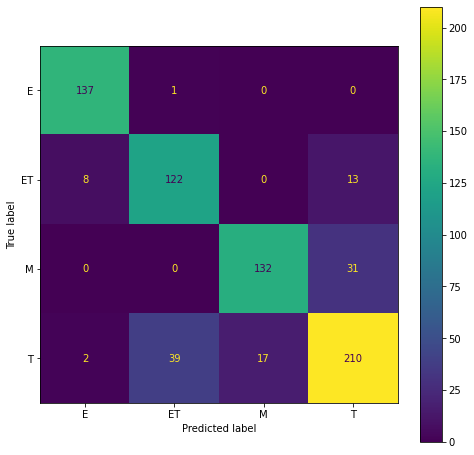

              precision    recall  f1-score   support

           E       0.93      0.99      0.96       138
          ET       0.75      0.85      0.80       143
           M       0.89      0.81      0.85       163
           T       0.83      0.78      0.80       268

    accuracy                           0.84       712
   macro avg       0.85      0.86      0.85       712
weighted avg       0.85      0.84      0.84       712

Accuracy:84.41%


In [56]:
#rfc confusion matrix
classification(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    classifier=bestrfcrefine1)

In [57]:
#best parameter
rfc_grid_search1.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 50,
 'random_state': 7}

In [58]:
#rfc model test score
bestrfcrefine1.score(X_test,y_test)

0.8441011235955056

In [59]:
#rfc model training score
bestrfcrefine1.score(X_train,y_train)

0.9204339963833634

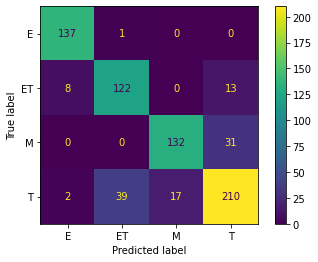

In [60]:
#confusion matrix results for trained data against test
plot_confusion_matrix(estimator=bestrfcrefine1, X=X_test, y_true=y_test)

# 2nd Refined Models

### Decision Tree Refined

In [61]:
##Fit decision tree, applying parameters to refine search
dtc_param_grid2 = {
    'criterion': ['gini'],
    'max_depth': [None],
    'min_samples_leaf': [1],
    'min_samples_split': [2]
}

In [62]:
#Search for best estimator
bestdtcrefine2 = dtc_grid_search1.best_estimator_

In [63]:
#GridSearchCV on DTC
dtc_grid_search = GridSearchCV(dtc, dtc_param_grid2, cv=3, return_train_score=True)

dtc_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': [None],
                         'min_samples_leaf': [1], 'min_samples_split': [2]},
             return_train_score=True)

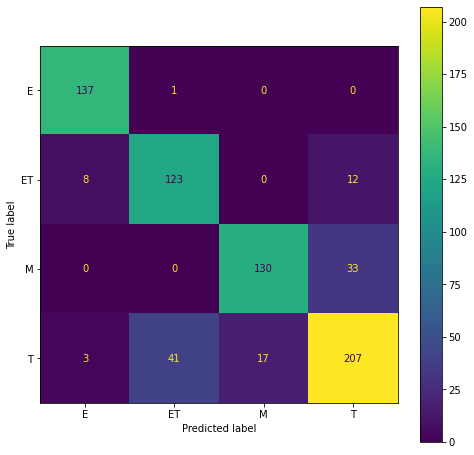

              precision    recall  f1-score   support

           E       0.93      0.99      0.96       138
          ET       0.75      0.86      0.80       143
           M       0.88      0.80      0.84       163
           T       0.82      0.77      0.80       268

    accuracy                           0.84       712
   macro avg       0.84      0.86      0.85       712
weighted avg       0.84      0.84      0.84       712

Accuracy:83.85%


In [64]:
#Confusion matrix
classification(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    classifier=bestdtcrefine2)

- Model on training set
    - Numbers on the Bottom/Left indicate failure based off of recall metric to catch harmful content from falling into lower ESRB ratings
    - Numbers on Top/Right indicate a game receiving a stricter rating than is required, while this could impact outreach and sales, questionable content is caught from lower ratings

In [65]:
#dtc model test score
bestdtcrefine2.score(X_test,y_test)

0.8384831460674157

In [66]:
#dtc model training score
bestdtcrefine2.score(X_train,y_train)

0.9282700421940928

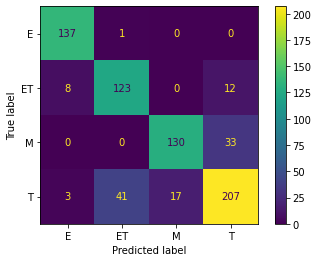

In [67]:
#confusion matrix results for trained data against test
plot_confusion_matrix(estimator=bestdtcrefine2, X=X_test, y_true=y_test)

### KNN Refined Model

In [68]:
##Fit knn, applying parameters to refine search
knn_para_grid2 = {
    'algorithm': ['brute'],
    'n_neighbors': [5],
    'p': [1],
    'weights': ['distance']
}

In [69]:
#GridSearch on Knn
knn_grid_search1 = GridSearchCV(knn, knn_para_grid2, cv=3, return_train_score=True)

knn_grid_search1.fit(X_train, y_train)

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['brute'], 'n_neighbors': [5], 'p': [1],
                         'weights': ['distance']},
             return_train_score=True)

In [70]:
#Search for best estimator
bestknnrefine2 = dtc_grid_search1.best_estimator_

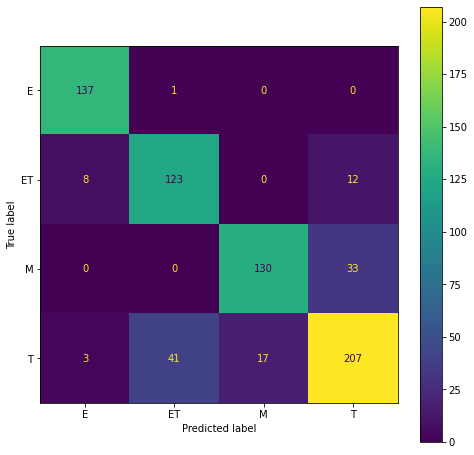

              precision    recall  f1-score   support

           E       0.93      0.99      0.96       138
          ET       0.75      0.86      0.80       143
           M       0.88      0.80      0.84       163
           T       0.82      0.77      0.80       268

    accuracy                           0.84       712
   macro avg       0.84      0.86      0.85       712
weighted avg       0.84      0.84      0.84       712

Accuracy:83.85%


In [71]:
#Knn confusion matrix
classification(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    classifier=bestknnrefine2)

- Model on training set
    - Numbers on the Bottom/Left indicate failure based off of recall metric to catch harmful content from falling into lower ESRB ratings
    - Numbers on Top/Right indicate a game receiving a stricter rating than is required, while this could impact outreach and sales, questionable content is caught from lower ratings

In [72]:
#rfc model test score
bestknnrefine2.score(X_test,y_test)

0.8384831460674157

In [73]:
#rfc model training score
bestknnrefine2.score(X_train,y_train)

0.9282700421940928

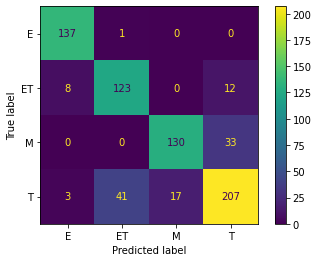

In [74]:
#confusion matrix results for trained data against test
plot_confusion_matrix(estimator=bestknnrefine2, X=X_test, y_true=y_test)

### Random Forest Refined

In [75]:
##Fit rfc, applying parameters to refine search
rfc_param_grid2 = {
    'criterion':['gini'],
    'max_depth':[None],
    'max_features':['sqrt'],
    'min_samples_leaf':[1],
    'min_samples_split':[2],
    'n_estimators':[100],
    'random_state':[7]
}

In [76]:
#GridSearch on rfc
rfc_grid_search1 = GridSearchCV(rfc, rfc_param_grid2, cv=3,n_jobs=10, return_train_score=True)

rfc_grid_search1.fit(X_train, y_train)

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=10,
             param_grid={'criterion': ['gini'], 'max_depth': [None],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [100],
                         'random_state': [7]},
             return_train_score=True)

In [77]:
#best estimator
bestrfcrefine2 = rfc_grid_search1.best_estimator_

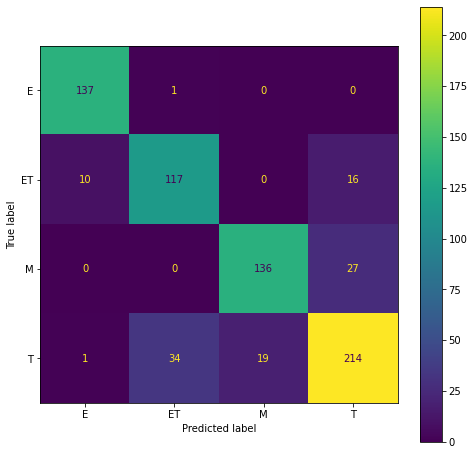

              precision    recall  f1-score   support

           E       0.93      0.99      0.96       138
          ET       0.77      0.82      0.79       143
           M       0.88      0.83      0.86       163
           T       0.83      0.80      0.82       268

    accuracy                           0.85       712
   macro avg       0.85      0.86      0.86       712
weighted avg       0.85      0.85      0.85       712

Accuracy:84.83%


In [78]:
#rfc confusion matrix
classification(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    classifier=bestrfcrefine2)

- Model on training set
    - Numbers on the Bottom/Left indicate failure based off of recall metric to catch harmful content from falling into lower ESRB ratings
    - Numbers on Top/Right indicate a game receiving a stricter rating than is required, while this could impact outreach and sales, questionable content is caught from lower ratings

In [79]:
#rfc model test score
bestrfcrefine2.score(X_test,y_test)

0.848314606741573

In [80]:
#rfc model training score
bestrfcrefine2.score(X_train,y_train)

0.9282700421940928

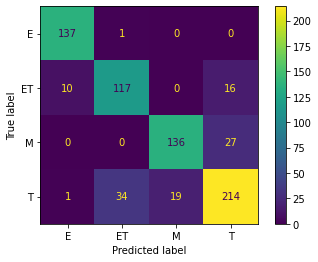

In [81]:
#confusion matrix results for trained data against test
plot_confusion_matrix(estimator=bestrfcrefine2, X=X_test, y_true=y_test)

# INTERPRET

## Decision Tree Feature Importances

In [82]:
#What features carry the most weight
dtc.feature_importances_

array([0.01784615, 0.0140839 , 0.00476678, 0.06744222, 0.07490772,
       0.00815428, 0.02553018, 0.01400013, 0.10750179, 0.0248188 ,
       0.0366038 , 0.01284706, 0.00180173, 0.01737061, 0.0069748 ,
       0.07029045, 0.00705814, 0.01027436, 0.01713166, 0.01488354,
       0.15477959, 0.00259561, 0.00561145, 0.00805849, 0.02256613,
       0.02058129, 0.1377079 , 0.01416061, 0.03179736, 0.01360245,
       0.00403544, 0.03021558])

In [83]:
Feature_Importances=pd.DataFrame({"feature":X_train.columns,"importance":dtc.feature_importances_})
Feature_Importances.sort_values("importance")

,feature,importance
12,mature_humor,0.001802
21,nudity,0.002596
30,use_of_drugs_and_alcohol,0.004035
2,animated_blood,0.004767
22,partial_nudity,0.005611
14,mild_cartoon_violence,0.006975
16,mild_language,0.007058
23,sexual_content,0.008058
5,cartoon_violence,0.008154
17,mild_lyrics,0.010274


## Random Forest Feature Importances

In [84]:
#What features carry the most weight
rfc.feature_importances_

array([0.02626594, 0.01898434, 0.00540822, 0.09249108, 0.07487727,
       0.01391643, 0.02400386, 0.0092664 , 0.10594765, 0.02573275,
       0.03778366, 0.01232502, 0.00409742, 0.02115069, 0.01030021,
       0.04297501, 0.00837722, 0.01471518, 0.01771367, 0.01965154,
       0.12242313, 0.00280991, 0.00946357, 0.00973215, 0.01987374,
       0.01869983, 0.11303367, 0.02095645, 0.0344074 , 0.01289508,
       0.00780098, 0.04192052])

In [85]:
Feature_Importances=pd.DataFrame({"feature":X_train.columns,"importance":rfc.feature_importances_})
Feature_Importances.sort_values("importance")

,feature,importance
21,nudity,0.002810
12,mature_humor,0.004097
2,animated_blood,0.005408
30,use_of_drugs_and_alcohol,0.007801
16,mild_language,0.008377
7,drug_reference,0.009266
22,partial_nudity,0.009464
23,sexual_content,0.009732
14,mild_cartoon_violence,0.010300
11,lyrics,0.012325


In [86]:
combined_csv.groupby("esrb_rating")["no_descriptors"].value_counts()
#How many No Descriptors exist in each category

esrb_rating  no_descriptors
E            1                 311
             0                 196
ET           0                 504
             1                  16
M            0                 472
             1                   4
T            0                 826
             1                  42
Name: no_descriptors, dtype: int64

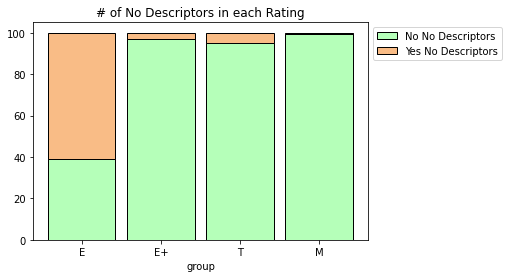

In [87]:
# Data
r = [0,1,2,3]
No_Descriptor = {'E': [201, 512, 830, 473], 'ET': [315, 17, 43, 4]}
df = pd.DataFrame(No_Descriptor)

#From raw value to percentage
totals = [i+j for i,j in zip(df['E'], df['ET'])]
greenBars = [i / j * 100 for i,j in zip(df['E'], totals)]
orangeBars = [i / j * 100 for i,j in zip(df['ET'], totals)]
# plot
barWidth = 0.85
names = ('E','E+','T','M')
# Create green Bars
plt.bar(r, greenBars, color='#b5ffb9', edgecolor='black', width=barWidth, label="No No Descriptors")
# Create orange Bars
plt.bar(r, orangeBars,bottom=greenBars, color='#f9bc86', edgecolor='black', width=barWidth, label="Yes No Descriptors")
# Custom x axis
plt.xticks(r, names)
plt.xlabel("group")
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
# Show graphic
plt.title(label='# of No Descriptors in each Rating')
plt.show()

- No Descriptors has a significant impact on the E ratings

# CONCLUSIONS & RECCOMENDATIONS

- Next steps
    - Research what makes up 'No Descriptors' category to futher analyze its impact on E Rating
    - Explore further correlations and groupings to improve models